In [26]:
mb_solve_json = """
{
  "ob_atom": {
    "decays": [
      {
        "channels": [[0, 1]],
        "rate": 0.0
      }
    ],
    "energies": [],
    "fields": [
      {
        "coupled_levels": [[0, 1]],
        "detuning": 0.0,
        "detuning_positive": true,
        "label": "probe",
        "rabi_freq": 1.0e-3,
        "rabi_freq_t_args": {
          "ampl_1": 1.0,
          "centre_1": 0.0,
          "fwhm_1": 0.1
        },
        "rabi_freq_t_func": "gaussian_1"
      }
    ],
    "num_states": 2
  },
  "t_min": -20.0,
  "t_max": 100.0,
  "t_steps": 10000,
  "z_min": -0.2,
  "z_max": 1.2,
  "z_steps": 100,
  "z_steps_inner": 100,
  "num_density_z_func": "square_1",
  "num_density_z_args": {
    "on_1": 0.0,
    "off_1": 1.0,
    "ampl_1": 1.0
  },
  "interaction_strengths": [
    10.0
  ],
  "velocity_classes": {
    "thermal_delta_min": -0.0,
    "thermal_delta_max": 0.0,
    "thermal_delta_steps": 0,
    "thermal_delta_inner_min": 0.0,
    "thermal_delta_inner_max": 0.0,
    "thermal_delta_inner_steps": 0,
    "thermal_width": 1.0
  },
  "method": "mesolve",
  "opts": {},
  "savefile": "08-mb-solve-two-weak-gaussian-narrow-ab-highfreq"
}
"""

In [ ]:
from maxwellbloch import mb_solve
mb_solve_00 = mb_solve.MBSolve().from_json_str(mb_solve_json)

Omegas_zt, states_zt = mb_solve_00.mbsolve(step='ab', recalc=True)


  0%|          | 0/100 [00:00<?, ?it/s]
Exception in thread Thread-7:
Traceback (most recent call last):
  File "/Users/tommy/.miniconda3/envs/mb/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/Users/tommy/.miniconda3/envs/mb/lib/python3.5/site-packages/tqdm/_tqdm.py", line 102, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/tommy/.miniconda3/envs/mb/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



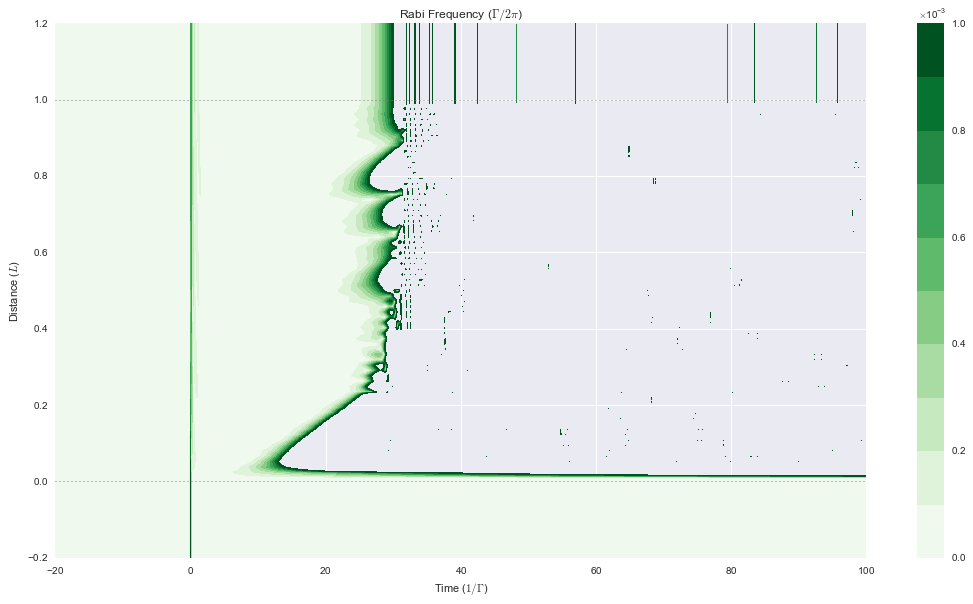

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np

fig, ax = plt.subplots(figsize=(16, 9))
cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(mb_solve_00.tlist, mb_solve_00.zlist, 
                 np.abs(mb_solve_00.Omegas_zt[0]/(2*np.pi)), 
                 cmap_range, cmap=plt.cm.Greens)
ax.set_title('Rabi Frequency ($\Gamma / 2\pi $)')
ax.set_xlabel('Time ($1/\Gamma$)')
ax.set_ylabel('Distance ($L$)')
for y in [0.0, 1.0]:
    ax.axhline(y, c='grey', lw=1.0, ls='dotted')
plt.colorbar(cf);

In [20]:
def field_fft(Omega_zt, tlist):

    Omega_fft = np.zeros(Omega_zt.shape, dtype=np.complex)

    t_step = tlist[1] - tlist[0]
    freq_range = np.fft.fftfreq(len(tlist), t_step) # FFT Freq
    freq_range = np.fft.fftshift(freq_range)

    for i, Omega_z_i  in enumerate(Omega_zt):

        Omega_fft[i] = np.fft.fft(Omega_z_i)
        Omega_fft[i] = np.fft.fftshift(Omega_fft[i])

    Omega_abs_freq = np.abs(Omega_fft)
    Omega_angle_freq = np.angle(Omega_fft)

    return freq_range, Omega_abs_freq, Omega_angle_freq

In [21]:
freq_range, Omega_abs_freq, Omega_angle_freq = field_fft(mb_solve_00.Omegas_zt[0], mb_solve_00.tlist)

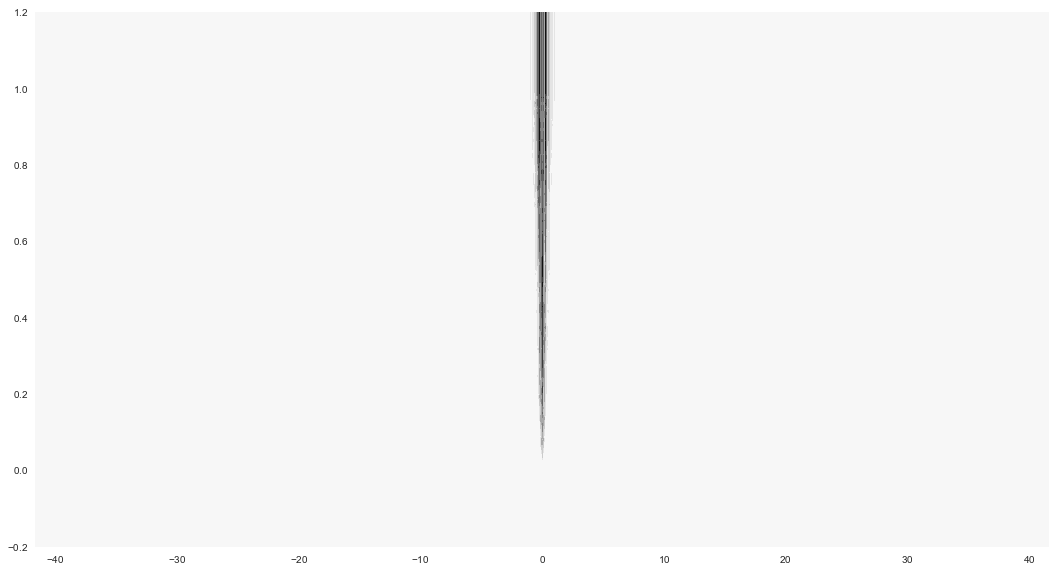

In [22]:
fig, ax = plt.subplots(figsize=(16, 9))
#cmap_range = np.linspace(0.0, 1.0e-3, 11)
cf = ax.contourf(freq_range, mb_solve_00.zlist, 
                 Omega_abs_freq) #, 
                 #cmap_range, cmap=plt.cm.Greens)

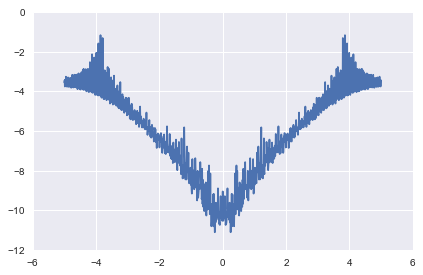

In [23]:
# Value proportional to susc
susc_im = -np.log(Omega_abs_freq[-1]/Omega_abs_freq[0])
susc_re = Omega_angle_freq[0] - Omega_angle_freq[-1]

freq_lim = [-5.0, 5.0]

freq_min_idx = np.min(np.where(freq_range >= freq_lim[0]))
freq_max_idx = np.max(np.where(freq_range <= freq_lim[1]))

freq_range = freq_range[freq_min_idx:freq_max_idx]
susc_im = susc_im[freq_min_idx:freq_max_idx]
susc_re = susc_re[freq_min_idx:freq_max_idx]

ax = fig.add_subplot(211)
plt.plot(freq_range, susc_im)